# <b>Required Imports</b>

In [1]:
import pickle,sys,os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [2]:
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset0.pkl?raw=true
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset1.pkl?raw=true
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset2.pkl?raw=true
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset3.pkl?raw=true

--2021-12-30 11:45:44--  https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset0.pkl?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/GastonMazzei/TraceMeOut/raw/main/processed_trace/Dataset0.pkl [following]
--2021-12-30 11:45:44--  https://github.com/GastonMazzei/TraceMeOut/raw/main/processed_trace/Dataset0.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GastonMazzei/TraceMeOut/main/processed_trace/Dataset0.pkl [following]
--2021-12-30 11:45:44--  https://raw.githubusercontent.com/GastonMazzei/TraceMeOut/main/processed_trace/Dataset0.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

In [3]:
!ls

'Dataset0.pkl?raw=true'   sample_data


In [4]:
with open('Dataset0.pkl?raw=true','rb') as f:
  data = pickle.load(f)

# NEW! We load data from all processors! :-)
# datas = {}
# for n in [0,1,2,3]:
#   with open(f'Dataset{n}.pkl?raw=true','rb') as f:
#     datas[n] = pickle.load(f)

#<b>Configuration File: architecture & hyperparameters</b>

(<i>If the datasets change in the repo, non-architectural information should be updated using the configuration.py file. Most probably an error will be raised because of size mismatch if this is not updated.</i>)

In [51]:

# Model-specific parameters
T=8 # duration of the window in dt units
dt = 100000 # time in microseconds
UNIQUES=3807  #number of unique ids
MI=5709  #max number of interactions
ML=5712  #max number of leaves
NCATEGORIES=2

# Architectural parameters
ACT1 = 'relu'
FILTERS1 = 4
KSIZE1 = (2,1)
PSIZE1 = (max([T//4,2]),)
NDENSE1 = 8
DROP1 = 0.4

ACT2 = 'relu'
FILTERS2 = 4
KSIZE2 = (2,2)
PSIZE2 = (max([T//2,2]),1)
stride = (1,1)
NDENSE2 = 8
DROP2 = 0.75

ACT3='relu'
NDENSE3=8
DROP3 = 0.4

# Training parameters
VAL=0.25
BATCH=10
EPOCHS=50
L=5 # a length used to generate random data just for testing
LR=0.05

# Extras
POOLING = False
PROCS=[3, 2, 0, 1]

In [52]:
# define two sets of inputs: 
input_shape_flavours = (BATCH, T, ML, 1)
input_shape_structure = (BATCH, T, MI, 2)
inputFlavours = tf.keras.Input(shape=input_shape_flavours[1:])
inputStructure = tf.keras.Input(shape=input_shape_structure[1:])

# the first branch operates on the first input (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
x = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS1,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
			input_shape = input_shape_flavours[1:]
			)(inputFlavours)
x = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS1 * 2,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
			)(x)
x = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS1 * 2,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
			)(x)
#x = tf.keras.layers.MaxPool1D(pool_size=PSIZE1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(DROP1)(x)
x = tf.keras.layers.Dense(NDENSE1, activation = ACT1)(x)
x = tf.keras.layers.Dropout(DROP1)(x)
x = tf.keras.layers.Dense(NDENSE1 // 2, activation = ACT1)(x)
x = tf.keras.layers.Dropout(DROP1)(x)
x = tf.keras.layers.Dense(NDENSE1 // 2 // 2, activation = ACT1)(x)
x = tf.keras.Model(inputs = inputFlavours, outputs=x)

# the second branch opreates on the second input (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
y = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS2,         KSIZE2,    stride,      'valid',  activation = ACT2,
			input_shape = input_shape_structure[1:]
			)(inputStructure)
y = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS2 * 2,         KSIZE2,       stride,      'valid',  activation = ACT2,
			)(y)
#y = tf.keras.layers.MaxPool2D(pool_size=PSIZE2)(y)
y = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS2 * 2,         KSIZE2,       stride,      'valid',  activation = ACT2,
			)(y)
y = tf.keras.layers.MaxPool2D(pool_size=PSIZE2)(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dropout(DROP2)(y)
y = tf.keras.layers.Dense(NDENSE2, activation = ACT2)(y)
y = tf.keras.layers.Dropout(DROP2)(y)
y = tf.keras.layers.Dense(NDENSE2 // 2, activation = ACT2)(y)
y = tf.keras.layers.Dropout(DROP2)(y)
y = tf.keras.layers.Dense(NDENSE2 // 2 // 2, activation = ACT2)(y)
y = tf.keras.Model(inputs = inputStructure, outputs=y)



# combine the output of the two branches
combined = tf.keras.layers.concatenate([x.output, y.output])
z = tf.keras.layers.Dropout(DROP3)(combined)
z = tf.keras.layers.Dense(NDENSE3, activation = ACT3)(z)
z = tf.keras.layers.Dropout(DROP3)(z)
z = tf.keras.layers.Dense(NDENSE3, activation = ACT3)(z)
z = tf.keras.layers.Dense(NCATEGORIES, activation="softmax")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)

# Compile the model :-)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[
								       #tf.keras.metrics.CategoricalCrossentropy(),
							         tf.keras.metrics.CategoricalAccuracy(),
                       #tf.keras.metrics.AUC(),
											])


# Print input size
print(model.summary())
IShape = model.input_shape
OShape = model.output_shape

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 8, 5709, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 input_19 (InputLayer)          [(None, 8, 5712, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_52 (Conv2D)             (None, 7, 5708, 4)   36          ['input_20[0][0]']               
                                                                                           

#<b>Building the dataset generators to feed the Neural Net</b>

In [53]:
X1, X20, Y = data['X1'],data['X2'],data['Y']
ONE_HOT_Y = np.zeros((len(Y),2))
for i in range(len(Y)):
    ONE_HOT_Y[i,Y[i]] = 1
ONE_HOT_Y = ONE_HOT_Y.astype('float32')
L = len(X1)
LTR = int(L*(1-VAL))
print(f"Old batch size was: {BATCH}")
B = 32
LTR = LTR//B * B # LTR is approximated to the closest multiple of B :-)
LVA = L - LTR
LVA = LVA // B * B # THe same for LVA
BATCH = (BATCH // B + 1) * B # And the same for Batch Size
print(f"New batch size is: {BATCH}, LVA and LTR are: {LVA}, {LTR} and L is {L}, ... does L>=LTR+LVA? {L>=(LTR+LVA)}")

assert(len(X1)==len(X20)==len(Y))

X1_TRACKER = []
for i_,X_ in enumerate(X1):
    X1_TRACKER.append((ML-len(X_)))
    X1[i_] = [float(x) / UNIQUES for x in X_]

X2 = [[] for _ in range(len(X20))]
X2_TRACKER = []
for i,X_ in enumerate(X20):
    c = 0
    for i_,y_ in enumerate(X_):
        for z in y_:
            X2[i] += [[float(i_)/ML,float(z)/ML]]
            c += 1
    X2_TRACKER.append(MI-c) 

print(X1[0][:5])
print(X2[0][:5])

def produce_data(A,B):
    w = list(range(A,B))
    np.random.shuffle(w)
    for i in w:
            yield (
                    ( tf.convert_to_tensor(np.asarray([ (X1[j] + [0.] * X1_TRACKER[j]) for j in range(i-T+1,i+1)]).reshape(1,T,-1,1)), 
                      tf.convert_to_tensor(np.asarray([ (X2[j] + [[0., 0.]] * X2_TRACKER[j]) for j in range(i-T+1,i+1)]).reshape(1,T,-1,2)),
                    ), 
                    tf.convert_to_tensor(ONE_HOT_Y[i:i+1,:].reshape(1,2)),
                  )


OS = (
          (tf.TensorSpec(shape=(None,T,ML,1), dtype=tf.float32),
          tf.TensorSpec(shape=(None,T,MI,2), dtype=tf.float32)),
          tf.TensorSpec(shape=(None,NCATEGORIES), dtype=tf.float32),
    )

print(f'Finished building the output structure')
trainD = tf.data.Dataset.from_generator(lambda: produce_data(T,LTR), output_signature=OS)#output_types=(tf.float32), output_shapes=OS)
print(f'Finished building the training dataset')
valD = tf.data.Dataset.from_generator(lambda: produce_data(LTR+T,L), output_signature=OS)# output_types=(tf.float32), output_shapes=OS)
print(f'Finished building the validation dataset')


Old batch size was: 10
New batch size is: 32, LVA and LTR are: 224, 608 and L is 853, ... does L>=LTR+LVA? True
[5.762098596077058e-48, 5.769543167906613e-48, 2.2854835516739744e-48, 2.292928123503532e-48, 5.776987739736169e-48]
[[0.0, 0.00017507002801120448], [0.0, 0.03413865546218487], [0.0, 0.038865546218487396], [0.0, 0.0469187675070028], [0.0, 0.05164565826330532]]
Finished building the output structure
Finished building the training dataset
Finished building the validation dataset


#<b>Training the Neural Net</b>

In [54]:
print(f'About to train! :-)')
history = model.fit(trainD, epochs=EPOCHS, batch_size=BATCH, validation_data=valD, verbose=2)
print('Finished training! :-)')

About to train! :-)
Epoch 1/50
600/600 - 48s - loss: 0.5982 - categorical_accuracy: 0.7233 - val_loss: 0.7818 - val_categorical_accuracy: 0.5527 - 48s/epoch - 79ms/step
Epoch 2/50
600/600 - 46s - loss: 0.5970 - categorical_accuracy: 0.7250 - val_loss: 0.7425 - val_categorical_accuracy: 0.5527 - 46s/epoch - 77ms/step
Epoch 3/50
600/600 - 46s - loss: 0.5949 - categorical_accuracy: 0.7250 - val_loss: 0.7883 - val_categorical_accuracy: 0.5527 - 46s/epoch - 77ms/step
Epoch 4/50
600/600 - 46s - loss: 0.5927 - categorical_accuracy: 0.7250 - val_loss: 0.7281 - val_categorical_accuracy: 0.5527 - 46s/epoch - 77ms/step
Epoch 5/50
600/600 - 46s - loss: 0.5939 - categorical_accuracy: 0.7250 - val_loss: 0.7313 - val_categorical_accuracy: 0.5527 - 46s/epoch - 77ms/step
Epoch 6/50
600/600 - 46s - loss: 0.5955 - categorical_accuracy: 0.7250 - val_loss: 0.7270 - val_categorical_accuracy: 0.5527 - 46s/epoch - 77ms/step
Epoch 7/50
600/600 - 46s - loss: 0.5922 - categorical_accuracy: 0.7250 - val_loss: 0.7

#<b>Plotting the Neural Net results</b>

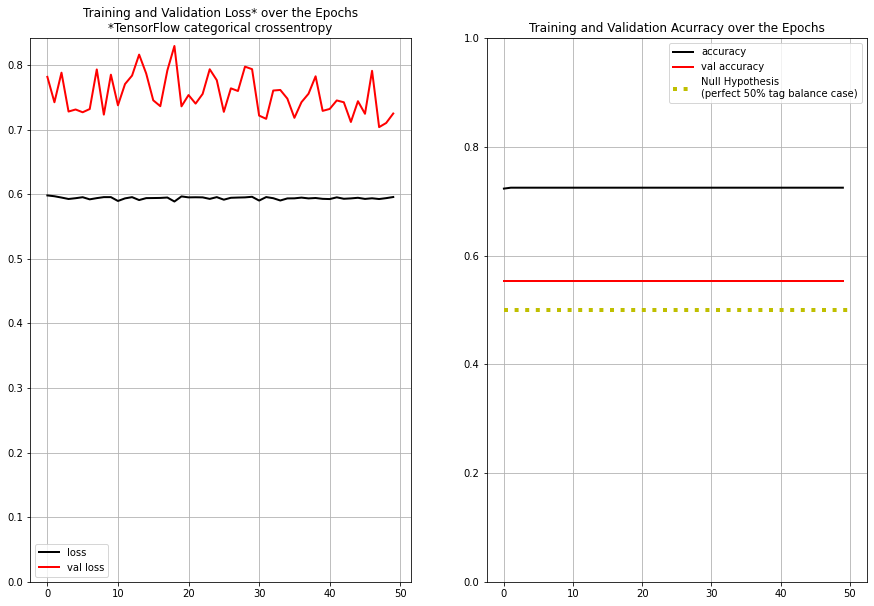

In [61]:
# Display results
f,ax = plt.subplots(1,2,figsize=(15,10))

ax[0].plot(history.history['loss'],label='loss', c='k', lw=2)
ax[0].plot(history.history['val_loss'], label='val loss', c='r', lw=2)
ax[0].grid()
ax[0].set_title('Training and Validation Loss* over the Epochs\n*TensorFlow categorical crossentropy')
ax[0].set_ylim(0,None)
ax[0].legend()

ax[1].plot(history.history['categorical_accuracy'],label='accuracy', c='k', lw=2)
ax[1].plot(history.history['val_categorical_accuracy'], label='val accuracy', c='r', lw=2)
ax[1].set_ylim(0,1)
ax[1].hlines(0.5, 0, EPOCHS, color='y', ls=':', lw=4, label='Null Hypothesis\n(perfect 50% tag balance case)')
ax[1].grid()
ax[1].set_title('Training and Validation Acurracy over the Epochs')
ax[1].legend()																																																																																																																																																																				

plt.show()

In [57]:
# Print the raw values of the metrics, just in case we want to use them without re-running the notebook :O
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history['categorical_accuracy'])
print(history.history['val_categorical_accuracy'])

[0.5982447266578674, 0.5969698429107666, 0.594936192035675, 0.5927329063415527, 0.5939357280731201, 0.5954844355583191, 0.5921755433082581, 0.594054639339447, 0.5956071019172668, 0.5956102609634399, 0.5896567702293396, 0.593674898147583, 0.5955753922462463, 0.5910670757293701, 0.5940710306167603, 0.594192624092102, 0.5943629741668701, 0.5949951410293579, 0.5888196229934692, 0.5967196822166443, 0.5952320098876953, 0.595394492149353, 0.5952397584915161, 0.5928781032562256, 0.5956092476844788, 0.5916368365287781, 0.5945946574211121, 0.5949538350105286, 0.5952386856079102, 0.5961313843727112, 0.590283215045929, 0.5956944227218628, 0.5939354300498962, 0.590394139289856, 0.5936046242713928, 0.5937320590019226, 0.5948633551597595, 0.5936342477798462, 0.5942476391792297, 0.5929570198059082, 0.592609167098999, 0.5952854156494141, 0.593050479888916, 0.5936325788497925, 0.5945742130279541, 0.5928395390510559, 0.5938271284103394, 0.5926558971405029, 0.5940397381782532, 0.5957786440849304]
[0.78180